# Quantum Kernels
En este Notebook, vamos a aprender como implementar quantum feature maps y quantum kernels para su aplicacion en la clasificacion mediante vectores de soporte en Qiskit.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Asegurarse de instalar sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
# Asegurarse de instalar el paquete de qiskit_machine_learning
# pip install qiskit-machine-learning
from qiskit_machine_learning.kernels import QuantumKernel

## Los datos

Los datos que vamos a utilizar en este Notebook son un subset del [handwritten digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset), que esta disponible por medio de `scikit-learn`. La meta es diferenciar entre los digitos '0' y '1'.

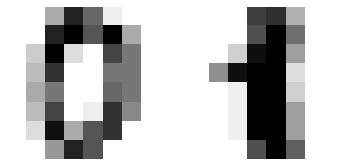

In [2]:
# Empezamos cargando el dataset del modulo 'dataset' de sklearn
digits = datasets.load_digits(n_class=2)

# Vamos a graficar un ejemplo de los digitos '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Pre-procesamiento de los datos
El dataset contiene 360 elementos. Cada elemento consiste en una imagen de dimension 8x8 de un digito, en su representacion en forma de un array o un vector multi-dimensional, donde cada elemento de dicho vector es un entero en el rango 0 (blanco) y 16 (negro). A continuacion, detallaremos el proceso de pre-procesamiento:

- El primer paso en el pre-procesamiento de los datos es crear dos subconjuntos de datos, el de entrenamiento, con 100 elementos y el de verificacion, con 20 elementos.

- El siguiente paso es el de ajustar la escala de los valores de blanco/negro al rango -1 y 1 para poder utilizar los datos en un modelo de clasificacion binaria.

- Ademas, necesitamos reducir la dimensionalidad de los datos para que iguale el numero de cubits que podemos emplear en nuestro modelo (en este caso, 4).


In [3]:
# Crear dos subconjuntos de datos: de entrenamiento y de validacion
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

In [4]:
sample_test.shape

(72, 64)

In [5]:
# Reducir la dimensionalidad mediante el metodo PCA
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

In [6]:
sample_test.shape

(72, 4)

In [7]:
sample_test[0]

array([ 15.74766818, -19.51605279,  27.74617746,  -5.94523814])

In [8]:
# Normalizacion
# Este metodo, es necesario para modelos de tipo support vector, que esperan
# que los datos esten centrados sobre 0.
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

In [9]:
sample_test[0]

array([ 0.71418217, -1.53067877,  2.71723432, -0.80572754])

In [10]:
# Ajustar el rango a -1,1
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [11]:
sample_test[0]

array([ 0.41948352, -0.83602799,  0.72200828, -0.373356  ])

In [12]:
# Seleccionar 100 elementos del conjunto de entrenamiento y 20 de validacion
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [13]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## Codificacion de datos
Recordamos que los datos de entrenamiento son clasicos y necesitamos codificarlos en un estado cuantico, utilizando, por ejemplo un `quantum feature map`. La seleccion del tipo de *feature map* a utilizar es crucial y depende del tipo de datos que necesitamos clasificar.

En este Notebook, vamos a utilizar los feature maps disponibles en Qiskit, antes de seleccionar uno y personalizarlo para codificar nuestros datos.

### Quantum Feature Maps
Un *quantum feature map* $\phi(\mathbf{x})$ es una transformacion del vector de caracteristicas clasico $\mathbf{x}$ al estado cuantico $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. Dicha transformacion es mediada por la transformacion unitaria $\mathcal{U}_{\Phi(\mathbf{x})}$ en el estado inicial $|0\rangle^{n}$ donde _n_ es el numero de cubits utilizados para la codificacion.

Los *feature maps* disponibles en Qiskit son los siguientes:

- [`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html) 
- [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
- [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)

y fueron desarrollados como parte del trabajo detallado en el articulo:  [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2).


El `PauliFeatureMap` se define de la siguiente manera:

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

y describe el operador unitario de longitud $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

que contiene una capa de compuertas de Hadamard entre bloques de entrelazamiento, $U_{\Phi(\mathbf{x})}$.

Dentro de los bloques de entrelazamiento, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ corresponde a las matrices de Pauli, el indice $S$ describe la conexion entre diferentes cubits o elementos de datos: $S \in \{\binom{n}{k}\ combinaciones,\ k = 1,... n \}$, y por default la funcion de mapeo $\phi_S(\mathbf{x})$ es: 

$$
\phi_S:\mathbf{x}\mapsto x_i if S=\{i\},  y  \\ 
\phi_S:\mathbf{x}\mapsto (\pi-x_i)(\pi-x_j) if S=\{i,j\}\\
$$

cuando $k = 1, P_0 = Z$, el `ZFeatureMap` es el siguiente: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

y se define como:
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

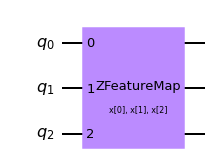

In [14]:
# 3 features, longitud 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.draw('mpl')

![ZFeature](ZFeature.png)

aqui, la falta de entrelazamiento implica que es una rutina o circuito que es facil de simular clasicamente y no provee ventaja cuantica.

Cuando $k = 2, P_0 = Z, P_1 = ZZ$, este caso corresponde al `ZZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

que se define como:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

In [ ]:
# 3 features, longitud 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.draw('mpl')

![ZZFeature](ZZFeature.png)

Ahora que tenemos capas entrelazadoras, podemos definir diferentes configuraciones. Si ahora utilizamos la opcion 'circular':

```python
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.draw('mpl')
```

![ZZFeatureCircular](ZZFeatureCircular.png)

Si ahora utilizamos la opcion 'linear':

```python
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.draw('mpl')
```

![ZZFeatureCircular](ZZFeatureLinear.png)

Tambien podemos cambiar las compuertas de Pauli en el feature map, por ejemplo, $P_0 = X, P_1 = Y, P_2 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

```python
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.draw('mpl')
```
![ZFeaturePauli](ZFeaturePauli.png)

Tambien podemos definir nuestra propia funcion de mapeo, por ejemplo: 

In [15]:
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [ ]:
map_customdatamap = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

Las funciones [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) y [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) en la libreria de circuitos de Qiskit's tambien se pueden utilizar para crear parameterised quantum circuits y usarlos como feature maps. 

```python
TwoLocal(num_qubits=None, reps=3, rotation_blocks=None, 
         entanglement_blocks=None, entanglement='full',  
         skip_unentangled_qubits=False, 
         skip_final_rotation_layer=False, 
         parameter_prefix='θ', insert_barriers=False, 
         initial_state=None)
```

```python
NLocal(num_qubits=None, reps=1, rotation_blocks=None, 
       entanglement_blocks=None, entanglement=None,   
       skip_unentangled_qubits=False, 
       skip_final_rotation_layer=False, 
       overwrite_block_parameters=True, 
       parameter_prefix='θ', insert_barriers=False, 
       initial_state=None, name='nlocal')
```

Ambas funciones crean circuitos parameterizados con capas alternando entre compuertas de rotacion y entrelazamiento. En las dos capas, 

Por ejemplo, podemos usar el circuito `TwoLocal` con compuertas $R_y$ and $R_Z$ en la capa de rotacion y $CX$ como entrelazamiento de manera circular: 

In [ ]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)

![TwoLocal](TwoLocal.png)

Este es otro circuito `NLocal`, con un bloque de rotacion en 2 cubits y un bloque de entrelazamiento en 4 cubits utilizando entrelazamioento lineal:

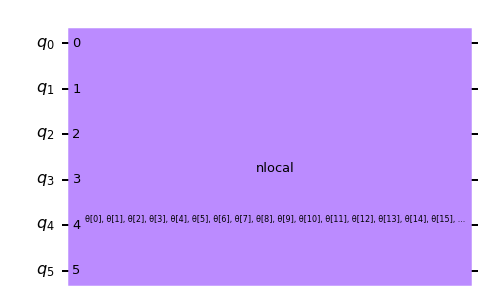

In [16]:
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.draw('mpl')

Ahora vamos a codificar nuestros datos de entrenamiento utilizando el `ZZFeatureMap`:

In [17]:
print(sample_train[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


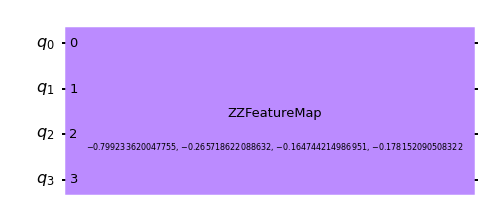

In [19]:
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.draw(output='mpl')

![DataEncoding](DataEncoding.png)

### Ejercicio: 
Codifica el vector $x = (-0.1,0.2)$ utilizando el `ZZFeatureMap` con 4 repeticiones y la funcion default de mapeo.

In [ ]:
x = [-0.1,0.2]

# Tu codigo aqui